This notebook uses `astroquery` to search for an image from the [Faint Images of the Radio Sky at Tewnty-cm (FIRST)](https://sundog.stsci.edu/) VLA radio survey and plots it using `matplotlib`.  The source was chosen to match the [documentation](https://astroquery.readthedocs.io/en/latest/image_cutouts/first/first.html) for `astroquery.image_cutouts.first`.

# Imports

In [1]:
from astroquery.image_cutouts.first import First
from astropy import coordinates
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

# Configuration

In [2]:
# Central Right Ascension coordinate for query
RA = coordinates.Angle("10h50m6.6s")
# Central Declination coordinate for query
DEC = coordinates.Angle("30d40m35s")
# Coordinate system frame
FRAME = "icrs"

# Retrieve FITS image

In [3]:
with First.get_images(coordinates.SkyCoord(RA, DEC, frame=FRAME)) as hdu_list:
    image = hdu_list[0].data
    image_units = hdu_list[0].header["BUNIT"]
    object_name = hdu_list[0].header["OBJECT"]
    ra_center = hdu_list[0].header["CRVAL1"] * u.deg
    dec_center = hdu_list[0].header["CRVAL2"] * u.deg

# Default image size is 1 arcmin on each side
image_size_ra = 1 * u.arcmin
image_size_dec = 1 * u.arcmin
pix_width_ra = image_size_ra / image.shape[1]
pix_width_dec = image_size_dec / image.shape[0]

# Plot

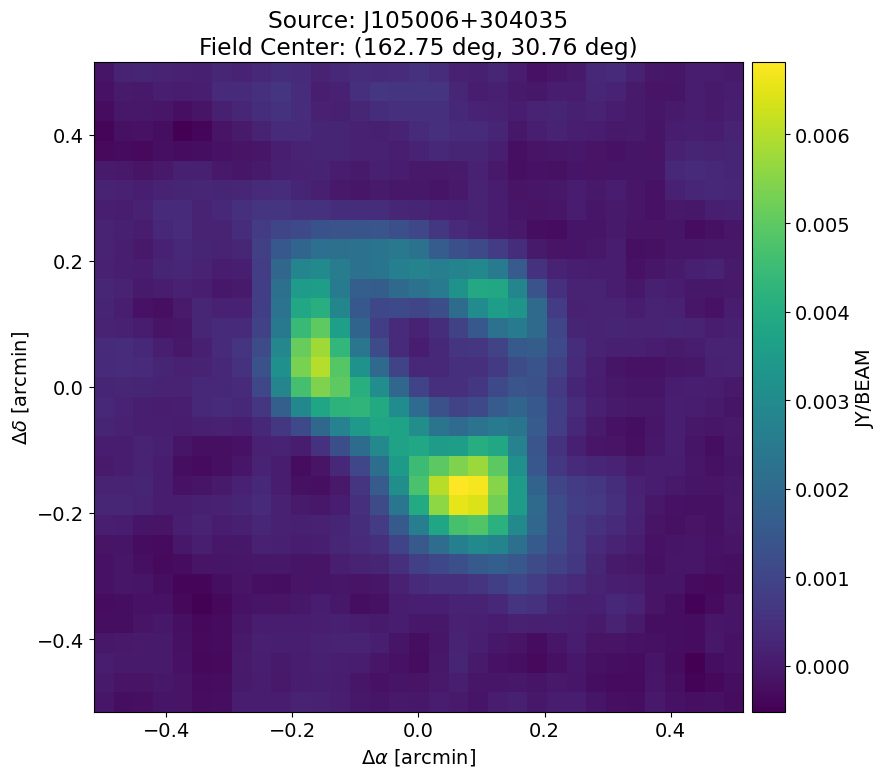

In [4]:
extent = [
    -(image_size_ra + pix_width_ra).to("arcmin").value/2,
    (image_size_ra + pix_width_ra).to("arcmin").value/2,
    -(image_size_dec + pix_width_dec).to("arcmin").value/2,
    (image_size_dec + pix_width_dec).to("arcmin").value/2
]
title = (
    f"Source: {object_name}"
    + "\n"
    + fr"Field Center: ({ra_center:.2f}, {dec_center:.2f})"
)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title(title)
ax.set_xlabel(r"$\Delta\alpha$ [arcmin]")
ax.set_ylabel(r"$\Delta\delta$ [arcmin]")
im = ax.imshow(image, extent=extent, origin="lower")
cb = fig.colorbar(im, ax=ax, pad=0.01, label=image_units)
fig.tight_layout();